<!-- dom:TITLE: Programmation Python  pour les mathématiques -->
# Numerical methods for time-dependent PDE
## TP1 - Transport equation with constant coefficients
<!-- dom:AUTHOR: Julien Guillod at [Sorbonne Université](http://www.sorbonne-universite.fr/), -->
<!-- Author: -->
**Julien Guillod**, [Sorbonne Université](http://www.sorbonne-universite.fr/),
Licence <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">CC BY-NC-ND</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 1. Numerical Analysis

This exercice is solved at once, without following the proposed steps.

### Main implementation

In order to allow time-stepping methods to store pre-computed values, it is convinient to define the following class:

In [2]:
# Template for one time step
class NumericalMethod(object):
    def __init__(self, pb):
        self.cfl = pb.cfl
    def __call__(self,u):
        raise NotImplementedError

For time-stepping methods that do not require initialisation, the following decorator transforms a function of u,cfl into a NumericalMethod object:

In [3]:
def convert(function):
    class out(NumericalMethod):
        def __call__(self, u):
            return function(u, self.cfl)
    #ugly hack to propagate name attribute
    out.__name__ = function.__name__
    return out

The following class is used to initalize and run a problem:

In [4]:
class Problem:
    
    def __init__(self):
        self.Lx = 1
        self.Nx = 100
        self.cfl = 0.3
        self.T = 0.3

    def update(self):
        self.x = np.linspace(0, self.Lx, self.Nx, endpoint=False) # space grid
        self.dx = self.x[1]-self.x[0] # spatial step
        self.dt = self.cfl*self.dx # time step
        self.t = np.arange(0,self.T,self.dt) # time grid

    def u0(self):
        raise NotImplementedError    
            
    def exact(self, time):
        raise NotImplementedError
    
    def method(self, pb):
        raise NotImplementedError

    def run(self):
        self.update()
        method = self.method(self)
        errors = []
        # time stepping
        for time in self.t:
            if time == 0:
                u = self.u0(self.x)
            else:
                u = method(u)
            # compute error if required
            if hasattr(self,'norm'):
                errors.append(np.linalg.norm(u - self.exact(time), self.norm))
        self.u = u
        # rescale norm by dx
        if hasattr(self,'norm') and self.norm == np.inf:
            self.errors = np.array(errors)
        elif hasattr(self,'norm'):
            self.errors = np.array(errors)*self.dx**(1/self.norm)
        return u

The previous general class is explicited for the transport equation, with the corresponding schemes:

In [5]:
class TransportProblem(Problem):
    
    # Define exact solution
    def exact(self, time):
        return self.u0(self.x-time)
    
    # Timestep for Lax-Wendroff scheme (using slicing)
    @convert
    def lax_wendroff(u, CFL):
        du = np.zeros_like(u)
        du[1:-1] = (u[2:]-u[:-2])/2 + CFL*(2*u[1:-1]-u[2:]-u[:-2])/2
        du[0] = (u[1]-u[-1])/2 + CFL*(2*u[0]-u[1]-u[-1])/2
        du[-1] = (u[0]-u[-2])/2 + CFL*(2*u[-1]-u[0]-u[-2])/2
        u -= CFL*du
        return u
    
    # Timestep for Lax-Wendroff scheme (using for loop)
    @convert
    def lax_wendroff2(u,CFL):
        n = len(u)
        du = np.zeros(n)
        for j in range(n):
            du[j] = (u[(j+1) % n]-u[j-1])/2 + CFL*(2*u[j]-u[(j+1) % n]-u[j-1])/2
        u -= CFL*du
        return u
    
    # upwind scheme
    @convert
    def upwind(u, CFL):
        du = np.zeros_like(u)
        du[1:] = (u[1:]-u[:-1])
        du[0] = (u[0]-u[-1])
        u -= CFL*du
        return u
    
    # Centred explicit scheme
    @convert
    def centred_explicit(u, CFL):
        du = np.zeros_like(u)
        du[1:-1] = (u[2:]-u[:-2])/2
        du[0] = (u[1]-u[-1])/2
        du[-1] = (u[0]-u[-2])/2
        u -= CFL*du
        return u

    # Centred implicit scheme
    class centred_implicit(NumericalMethod):
        def __init__(self, prop):
            super().__init__(prop)
            CFL = prop.cfl
            # construction of the matrix A
            A = np.eye(prop.Nx) + CFL/2*np.eye(prop.Nx, k=1) - CFL/2*np.eye(prop.Nx, k=-1)
            # corrections for periodic conditions
            A[0,-1] = -CFL/2
            A[-1,0] = +CFL/2
            # inverse of the matrix A
            self.B = np.linalg.inv(A)
        def __call__(self,u):
            u[:] = np.dot(self.B, u)
            return u

    # Glimm scheme (all shifted at random)
    @convert
    def glimm(u, CFL):
        if np.random.rand() < CFL:
            u[:] = np.roll(u,1)
            return u
        else:
            return u

    # Monte-Carlo scheme (shifing at random)
    @convert
    def monte_carlo(u, CFL):
        new = np.zeros_like(u)
        for j in range(len(u)):
            if np.random.rand() < CFL:
                new[j] = u[j-1]
            else:
                new[j] = u[j]
        u[:] = new
        return u

### Tests

Definitions of the functions for the initial data:

In [6]:
def u01(x):
    return np.sin(2*np.pi*x)

@np.vectorize
def u02(x):
    x = x % 1
    if 0 <= x <= 1/4 or 3/4 <= x <= 1:
        return 0.
    else:
        return 1.

Testing the Lax-Wendroff scheme:

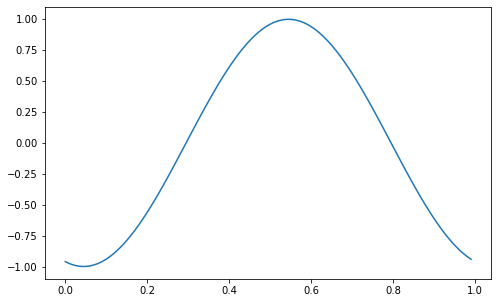

In [7]:
p = TransportProblem()
p.Nx = 100
p.T = 0.3
p.cfl = 0.5
p.method = p.lax_wendroff
p.u0 = u01
p.run()
plt.figure(figsize=(8,5))
plt.plot(p.x,p.u)
plt.show()

Comparaison between the implementation of Lax-Wendroff with slicing and with a *for* loop:

In [8]:
%%timeit
p = TransportProblem()
p.u0 = u01
p.method = p.lax_wendroff
p.run()

2.1 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
%%timeit
p = TransportProblem()
p.u0 = u01
p.method = p.lax_wendroff2
p.run()

16.9 ms ± 1.04 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Conclusion**: avoid *for* loop as much as possible!

### Convergence tests

Get errors at $t=T$ for various `Nx`:

In [10]:
@np.vectorize
def error_Nx(p,Nx):
    p.Nx = Nx
    p.run()
    return p.errors[-1]

Compare convergence for various spatial discretizations for the smooth initial data `u01`:

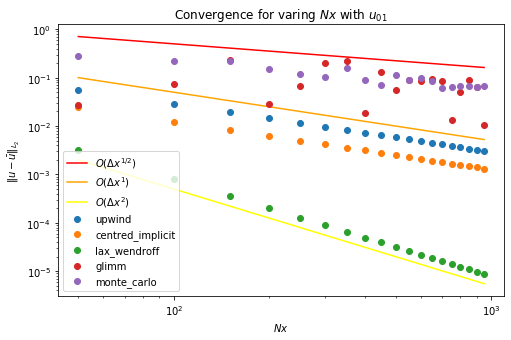

In [11]:
p = TransportProblem()
p.u0 = u01
p.norm = 2
# list of discretizations
NN = np.array(range(50,1000,50))
# list of methods
methods = [p.upwind, p.centred_implicit, p.lax_wendroff, p.glimm, p.monte_carlo]
# figure
plt.figure(figsize=(8,5))
plt.title(r"Convergence for varing $Nx$ with $u_{01}$")
plt.xlabel("$Nx$")
plt.ylabel(r'$\Vert u-\bar{u}\Vert_{L_2}$')
plt.loglog(NN,5*NN**-0.5, "r", label=r'$O(\Delta x^{1/2})$')
plt.loglog(NN,5/NN, "orange", label=r'$O(\Delta x^{1})$')
plt.loglog(NN,5/NN**2, "yellow", label=r'$O(\Delta x^{2})$')
for m in methods:
    p.method = m
    plt.loglog(NN, error_Nx(p,NN), "o", label=m.__name__)
plt.legend()
plt.show()

Compare the convergence for various spatial discretizations for non-smooth initial data `u02`:

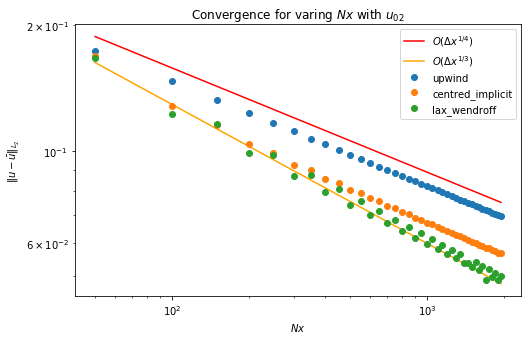

In [12]:
p = TransportProblem()
p.u0 = u02
p.norm = 2
# list of discretizations
NN = np.array(range(50,2000,50))
# list of methods
methods = [p.upwind, p.centred_implicit, p.lax_wendroff]
# figure
plt.figure(figsize=(8,5))
plt.title(r"Convergence for varing $Nx$ with $u_{02}$")
plt.xlabel("$Nx$")
plt.ylabel(r'$\Vert u-\bar{u}\Vert_{L_2}$')
plt.loglog(NN, 0.5*NN**-(1/4), "r", label=r'$O(\Delta x^{1/4})$')
plt.loglog(NN, 0.6*NN**-(1/3), "orange", label=r'$O(\Delta x^{1/3})$')
for m in methods:
    p.method = m
    plt.loglog(NN, error_Nx(p,NN), "o", label=m.__name__)
plt.legend()
plt.show()

The conclusion is that for smooth data, the order of convergence and independant of the choice of the norm, and are the ones found in the first exercice sheet, where enough smoothness is assumed.
For non-smooth data, like $u_{02}$, the order of convergence are affected and now depend on the choice of the norm. Obviously for the $L^\infty$-norm there is no convergence at all. For the $L^2$-norm, the order of convergence seems to be $1/4$. One can actually prove that for $BV$ initial data, the upwind scheme converges in $L^1$ with order $1/2$. By interpolation, we obtain the order of convergence in $L^p$:
$$\Vert u\Vert_{L^p} \lesssim \Vert u\Vert_{L^1}^{1/p} \Vert u \Vert_{L^\infty}^{1-1/p}.$$

# 2. Numerical modeling

Let $\sigma>0$. The exact solution when $d(n)=\sigma n$ is given by
$$
n(t,a) = \begin{cases}
e^{-\sigma t} n_0(a-t) & \text{for}\, t<a \,, \\
0 & \text{for}\, t\geq a \,. \\
\end{cases}
$$
Obviously the function $a \mapsto n(t,a)$ is never zero for any $t>0$.

For $d(n) = \sigma \sqrt{n_+}$, one can look at the solution under the form $n(t,a) = \varphi(t,a)$. In this case, the exact solution is given by
$$
n(t,a) = \begin{cases}
\bigl( \sqrt{n_0(a-t)} - \frac{\sigma t}{2} \bigr)_+^2 & \text{for}\, t<a \,, \\
0 & \text{for}\, t\geq a \,. \\
\end{cases}
$$
In particular if $M=\sup_{a} n_0(a) < \infty$, then the function $a \mapsto u(t,a)$ is trivial for $t>\frac{2\sqrt{M}}{\sigma}$.

The introduction of a non-zero birth coefficient makes the analysis more complicated, see for exemple *Theory of Nonlinear Age-Dependent Population Dynamics* by G.F. Webb.

Define the upwind scheme with RHS and boundary condition at $a=0$:

In [13]:
class ProblemRHS(Problem):
    
    def rhs(self,u):
        raise NotImplementedError
        
    def bc(self,u):
        return 0
        
    class method(NumericalMethod):
        def __init__(self, pb):
            self.cfl = pb.cfl
            self.dx = pb.dx
            self.dt = pb.dt
            self.rhs = pb.rhs
            self.sigma = pb.sigma
            pb.update()
            self.bc = pb.bc
        def __call__(self,u):
            # bulk
            du = np.zeros_like(u)
            du[1:] = (u[1:]-u[:-1])
            u -= self.cfl*du + self.rhs(u)*self.dt
            # set boundary condition
            u[0] = self.bc(u)
            return u

Subclass for a boundary condition given by
$$
n(t,0) = \int_0^\infty b(a)n(t,a) d a
$$
by default with $b=0$:

In [14]:
class VonFoersterProblem(ProblemRHS):
    
    def __init__(self):
        super().__init__()
        self.sigma = 1
        self.Lx = 10
        self.Nx = 100
        self.T = 1
        
    def birth(self, x):
        return 0*x
    
    def bc(self, u):
        return np.dot(self.birth(self.x),u)*self.dx

Define the RHS and corresponding exact solution with zero birth coefficient respectivly for $d(n)=-\sigma n$ and $d(n) = \sigma \sqrt{n_+}$:

In [15]:
class VonFoersterLinear(VonFoersterProblem):
    
    __name__ = "Von Foerster linear"
    
    def rhs(self, n):
        return self.sigma*n
    
    def exact(self, t):
        a = self.x
        return np.exp(-self.sigma*t)*self.u0(a-t) * (t<a)

In [16]:
class VonFoersterSqrt(VonFoersterProblem):
    
    __name__ = "Von Foerster sqrt"
    
    def rhs(self, n):
        return self.sigma*np.sqrt(np.maximum(0*n,n))
    
    def exact(self, t):
        a = self.x
        return (np.maximum(0, np.sqrt(self.u0(a-t)) - self.sigma*t/2) )**2 * (t<a)

Representation of the solutions for $b=0$ starting from some initial data:

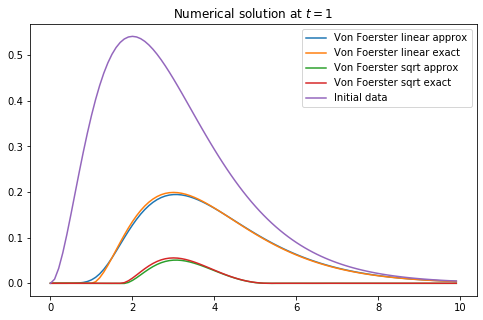

In [17]:
plt.figure(figsize=(8,5))
for p in [VonFoersterLinear(), VonFoersterSqrt()]:
    p.u0 = lambda a: a**2*np.exp(-a)
    p.run()
    plt.plot(p.x,p.u, label=p.__name__+" approx")
    plt.plot(p.x, p.exact(p.T), label=p.__name__+" exact")
plt.plot(p.x, p.u0(p.x), label="Initial data")
plt.title(f"Numerical solution at $t={p.T}$")
plt.legend()
plt.show()

Adding a non-zero birth condition:

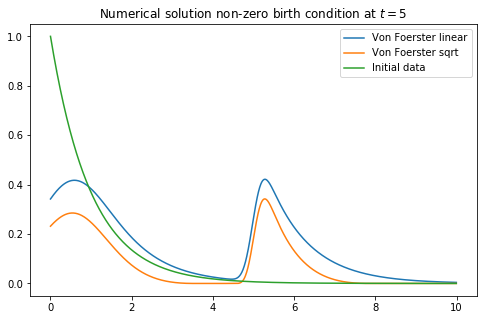

In [18]:
plt.figure(figsize=(8,5))
for p in [VonFoersterLinear(), VonFoersterSqrt()]:
    p.sigma = 0.1
    p.Nx = 1000
    p.T = 5
    p.u0 = lambda a: np.exp(-a)
    p.birth = lambda a: np.exp(-(a-5)**2)
    p.run()
    plt.plot(p.x,p.u, label=p.__name__)
plt.plot(p.x, p.u0(p.x), label="Initial data")
plt.title(f"Numerical solution non-zero birth condition at $t={p.T}$")
plt.legend()
plt.show()